In [24]:
## ---------------------------------------------------------
## Import libraries and functions
## ---------------------------------------------------------

using CSV
using DataFrames
using Turing, Flux, Plots, Random
using StatsBase
using StatsFuns: logistic
using MLBase
using StatsModels
using FreqTables
using KernelDensity
using JLD

Turing.turnprogress(true);
Turing.setadbackend(:reverse_diff)

include("functions.jl")

┌ Info: [Turing]: global PROGRESS is set as true
└ @ Turing /Users/kcft114/.julia/packages/Turing/m05p3/src/Turing.jl:24


res (generic function with 1 method)

In [9]:
## ---------------------------------------------------------
## Read and prepare data
## ---------------------------------------------------------

df_train = CSV.read("data/Aleo_train_match.csv")
df_test = CSV.read("data/Aleo_test_match.csv")
df_ambig = CSV.read("data/Aleo_ambig.csv")

names(df_test)

println(size(df_train))
println(size(df_test))
println(size(df_ambig))

df_Xtrain = df_train[!, [:ClogP, :BSEP, :Glu, :Glu_Gal, :THLE, :HepG2, :Fsp3, :log10cmax]]
df_Xtest = df_test[!, [:ClogP, :BSEP, :Glu, :Glu_Gal, :THLE, :HepG2, :Fsp3, :log10cmax]]
df_Xambig = df_ambig[!, [:ClogP, :BSEP, :Glu, :Glu_Gal, :THLE, :HepG2, :Fsp3, :log10cmax]]

df_y_train = df_train[!, :dili_sev]
df_y_test = df_test[!, :dili_sev];
df_y_ambig = df_ambig[!, :dili_sev];

# combine X and y in one column
df_yXtrain = hcat(df_y_train, df_Xtrain)
df_yXtest = hcat(df_y_test, df_Xtest)
df_yXambig = hcat(df_y_ambig, df_Xambig)

# formula for design matrix
f = @formula(x1 ~  0 + ClogP + BSEP + Glu + Glu_Gal + THLE + HepG2+ Fsp3  +  log10cmax +
                      ClogP * (BSEP + Glu + Glu_Gal + THLE + HepG2+ Fsp3) +
                              BSEP * (Glu + Glu_Gal + THLE + HepG2+ Fsp3) +
                                      Glu * (Glu_Gal + THLE + HepG2+ Fsp3) +
                                             Glu_Gal * (THLE + HepG2+ Fsp3)+
                                                        THLE * (HepG2+ Fsp3)+
                                                                HepG2 * Fsp3);

# model frame
mf_train = ModelFrame(f, df_yXtrain)
mf_test = ModelFrame(f, df_yXtest)
mf_ambig = ModelFrame(f, df_yXambig)
coefnames(mf_test)

mm_train = modelmatrix(mf_train)
mm_test = modelmatrix(mf_test)
mm_ambig = modelmatrix(mf_ambig)

y_train = Int.(convert(Array, df_y_train))
y_test = Int.(convert(Array, df_y_test))

println(sort(countmap(y_train)))
println(sort(countmap(y_test)))

X_train = convert(Matrix, mm_train)
X_test = convert(Matrix, mm_test);
X_ambig = convert(Matrix, mm_ambig);

X_train = slicematrix(X_train)
X_test = slicematrix(X_test)
X_ambig = slicematrix(X_ambig)

drug_names_train = df_train[:,:Drug];
drug_names_test = df_test[:,:Drug];
drug_names_ambig = df_ambig[:,:Drug];

size(X_train[1], 1) #number of features

(147, 12)
(37, 12)
(53, 12)
OrderedCollections.OrderedDict(1=>37,2=>45,3=>65)
OrderedCollections.OrderedDict(1=>10,2=>11,3=>16)


29

In [10]:
## ---------------------------------------------------------
## Network architechture: nodes_out, nodes_in, activation_function, include_bias_or_not
## ---------------------------------------------------------

network_shape = [(1, size(X_train[1], 1), :identity , 0)]

num_params = sum([i * o + i * b for (o, i, _, b) in network_shape]) 

29

In [11]:
## ---------------------------------------------------------
## Inference
## ---------------------------------------------------------

# uncomment this section to perform inference

# one chain:
num_samples = 20_000
ch2 = sample(bayes_nn(hcat(X_train...), y_train, network_shape, num_params), NUTS(num_samples, 0.65));

# for multiple chains:
#num_chains = 4
#num_samples = 20_000
#chains = mapreduce(c -> sample(bayes_nn(hcat(X_train...), y_train, network_shape, num_params), NUTS(num_samples, 0.65)), chainscat, 1:num_chains)

┌ Info: Found initial step size
│   init_ϵ = 0.4
└ @ Turing.Inference /Users/kcft114/.julia/packages/Turing/m05p3/src/inference/hmc.jl:365
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /Users/kcft114/.julia/packages/AdvancedHMC/YWXfk/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /Users/kcft114/.julia/packages/AdvancedHMC/YWXfk/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /Users/kcft114/.julia/packages/AdvancedHMC/YWXfk/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfi

In [10]:
## ---------------------------------------------------------
## Save/read results
## ---------------------------------------------------------

#write("chains/POLR.jls", ch2)

ch2 = read("chains/POLR.jls", Chains);

In [12]:
show(ch2)

Object of type Chains, with data of type 19000×42×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:19000
Thinning interval = 1
Chains            = 1
Samples per chain = 19000
internals         = eval_num, lp, acceptance_rate, hamiltonian_energy, is_accept, log_density, n_steps, numerical_error, step_size, tree_depth
parameters        = θ[27], c1, θ[22], θ[21], log_diff_c, θ[7], θ[10], θ[4], θ[15], θ[16], θ[11], θ[20], θ[19], θ[25], θ[8], θ[18], θ[13], θ[9], θ[1], θ[3], θ[5], θ[29], θ[24], θ[23], θ[12], θ[26], θ[14], θ[28], θ[17], θ[2], θ[6], sig

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean       │ std      │ naive_se    │ mcse       │ ess     │ r_hat    │
│     │ Symbol     │ Float64    │ Float64  │ Float64     │ Float64    │ Any     │ Any      │
├─────┼────────────┼────────────┼──────────┼─────────────┼────────────┼─────────┼──────────┤
│ 1   │ c1         │ -1.39008   │ 0.35272  │ 0.0025589   │ 0.00269538 │ 16869.3 

In [13]:
## ---------------------------------------------------------
## predict for training data
## ---------------------------------------------------------

#X = X_train
#y = y_train

# Extract the θ parameters from the sampled chain.
params2 = ch2[:θ].value.data

# cutpoints
e_log_diff_c = exp.(ch2[:log_diff_c].value.data)[:,1,1]
c1_est = ch2[:c1].value.data[:,1,1]
c2_est = c1_est + e_log_diff_c;

In [14]:
n_samps = size(ch2, 1)

19000

In [15]:
probs_mat_train, y_pred_samps_train, logpdf_mat_train, y_pred_train, eta_post_train = predict(X_train, y_train, n_samps);

In [16]:
## ---------------------------------------------------------
## metrics for training data
## ---------------------------------------------------------

waic = WAIC_logpfd(logpdf_mat_train)
tbl = freqtable(y_train)
ptbl = prop(tbl)
ptbl = convert(Array, ptbl)
v = vcat(fill(ptbl, length(y_train)))
probs_mat_freq = convert(Array{Float64,2}, hcat(v...)')

# model-based Brier score
cBrier_train = cumBrier(probs_mat_train, y_train)

# baseline Brier score
cBrier_BB_train = cumBrier(probs_mat_freq, y_train)

# Brier Skill score
BSS_train = (cBrier_BB_train .- cBrier_train) ./ cBrier_BB_train

y_pred = convert(Array{Int64,1}, y_pred_train);
y_train = convert(Array{Int64,1}, y_train);
C = confusmat(3, y_train, y_pred)
acc = (C[1,1] + C[2,2] + C[3,3]) / sum(C)
bacc = 1/3 *(C[1,1] / sum(C[1, :]) + C[2,2] / sum(C[2, :]) + C[3,3] / sum(C[3, :]))

println("WAIC = ", round(waic, digits=1))
println("mean cumBrier = ", round(mean(cBrier_train), digits=2))
println("median cumBrier = ", round(median(cBrier_train), digits=2))
println("mean BSS = ", round(mean(BSS_train), digits=2))
println("median BSS = ", round(median(BSS_train), digits=2))
println("Balanced accuracy = ", round(bacc, digits=2))
println("====== Confision Matrix:")
C

WAIC = 272.1
mean cumBrier = 0.14
median cumBrier = 0.1
mean BSS = 0.27
median BSS = 0.36
Balanced accuracy = 0.6
====== Confision Matrix:


3×3 Array{Int64,2}:
 23  11   3
  5  18  22
  1  14  50

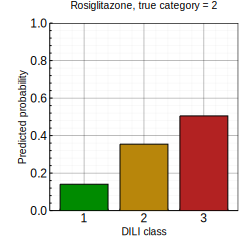

In [17]:
probsplot(drug_names_train, y_pred_samps_train, 62, y_train)

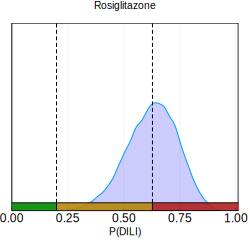

In [25]:
## extract predicted values and convert to 0-1 scale
post = logistic.(eta_post_train)
post_train = post

# cutpoints
c1 = logistic(mean(c1_est))
c2 = logistic(mean(c2_est))

postplot(drug_names_train, post_train, 62, y_train)

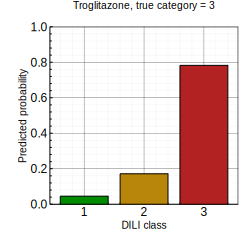

In [26]:
probsplot(drug_names_train, y_pred_samps_train, 115, y_train)

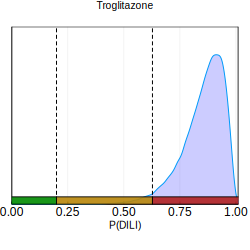

In [27]:
postplot(drug_names_train, post_train, 115, y_train)

In [28]:
## ---------------------------------------------------------
## Predict for test data
## ---------------------------------------------------------

#y = Y_test
#y_test = y;
#X = slicematrix(X_test)

probs_mat_test, y_pred_samps_test, logpdf_mat_test, y_pred_test, eta_post_test = predict(X_test,y_test, n_samps);

In [29]:
## ---------------------------------------------------------
## metrics for test data
## ---------------------------------------------------------

#dic = DIC_logpfd(logpdf_mat)
waic = WAIC_logpfd(logpdf_mat_test)

tbl = freqtable(y_test)
ptbl = prop(tbl)
ptbl = convert(Array, ptbl)
v = vcat(fill(ptbl, length(y_test)))
probs_mat_freq = convert(Array{Float64,2}, hcat(v...)')

# model-based Brier score
cBrier_test = cumBrier(probs_mat_test, y_test)

# baseline Brier score
cBrier_BB_test = cumBrier(probs_mat_freq, y_test)

# Brier Skill score
BSS_test = (cBrier_BB_test .- cBrier_test) ./ cBrier_BB_test


y_pred = convert(Array{Int64,1}, y_pred_test);
y_test = convert(Array{Int64,1}, y_test);
C = confusmat(3, y_test, y_pred)
acc = (C[1,1] + C[2,2] + C[3,3]) / sum(C)
bacc = 1/3 *(C[1,1] / sum(C[1, :]) + C[2,2] / sum(C[2, :]) + C[3,3] / sum(C[3, :]))

#println("DIC = ", round(dic, digits=1))
#println("WAIC = ", round(waic, digits=1))
println("mean cumBrier = ", round(mean(cBrier_test), digits=2))
println("median cumBrier = ", round(median(cBrier_test), digits=2))
println("mean BSS = ", round(mean(BSS_test), digits=2))
println("median BSS = ", round(median(BSS_test), digits=2))
#println("Accuracy = ", round(acc, digits=2))
println("Balanced accuracy = ", round(bacc, digits=2))
println("====== Confision Matrix:")
C

mean cumBrier = 0.16
median cumBrier = 0.12
mean BSS = 0.19
median BSS = 0.33
Balanced accuracy = 0.62
====== Confision Matrix:


3×3 Array{Int64,2}:
 8  1   1
 1  4   6
 1  4  11

In [81]:
#save("chains/polr_cBrier.jld", "polr_cBrier_train", cBrier_train, "polr_cBrier_test", cBrier_test, 
#                               "polr_BSS_train", BSS_train, "polr_BSS_test", BSS_test )

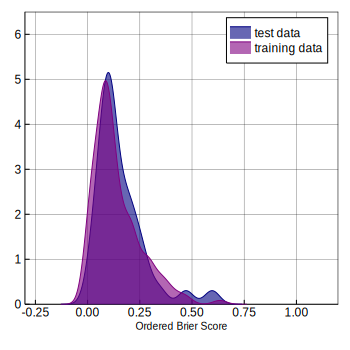

In [31]:
## ---------------------------------------------------------
## Plots
## ---------------------------------------------------------

k1 = kde(cBrier_train)
k2 = kde(cBrier_test)
p1 = plot(k2.x, k2.density,  
          color = :navy,
          fill = (0, 0.6, :navy), 
          label="test data", 
          yticks = true, 
          legend = :topright,
          #legend = false,
          #ylim=(0, 1.05 * maximum(vcat(k1.density, k2.density))),
          framestyle = :box,
          #title="Ordered Brier Score.",
          #titlefont = font(10, "Calibri"),
          size=[350,350],
          xlabel="Ordered Brier Score",
          xguidefontsize=font(7, "Calibri"),
          xlim = (-0.3, 1.2), 
          ylim = (0, 6.5),
          grid = :xy,
          gridopacity = 0.5)
plot!(k1.x, k1.density, color = :purple, fill = (0, 0.6, :purple), label="training data")

In [26]:
#savefig("figs/OBS_OL.pdf")

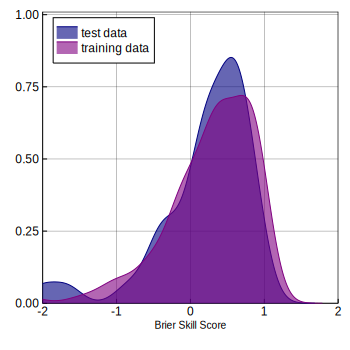

In [32]:
# Brier Skill score

k1 = kde(BSS_train)
k2 = kde(BSS_test)
p1 = plot(k2.x, k2.density,  
          color = :navy,
          fill = (0, 0.6, :navy), 
          label="test data", 
          yticks = true, 
          legend = :topleft,
          #legend = false,
          #ylim=(0, 1.05 * maximum(vcat(k1.density, k2.density))),
          framestyle = :box,
          #title="Ordered Brier Score.",
          #titlefont = font(10, "Calibri"),
          size=[350,350],
          xlabel="Brier Skill Score",
          xguidefontsize=font(7, "Calibri"),
          xlim = (-2, 2),
          ylim = (0, 1.01),
          grid = :xy,
          gridopacity = 0.5)
plot!(k1.x, k1.density, color = :purple, fill = (0, 0.6, :purple), label="training data")

In [33]:
#savefig("figs/BSS_OL.pdf")

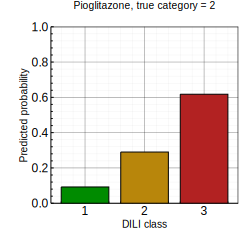

In [34]:
probsplot(drug_names_test, y_pred_samps_test, 6, y_test)

In [35]:
## extract predicted values and convert to 0-1 scale
post = logistic.(eta_post_test)
post_test = post

# cutpoints
c1 = logistic(mean(c1_est))
c2 = logistic(mean(c2_est))

0.6274972800146171

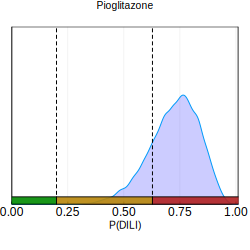

In [36]:
postplot(drug_names_test, post, 6, y_test)

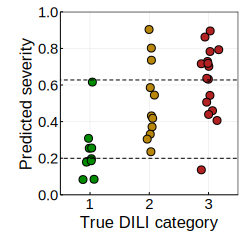

In [37]:
## ---------------------------------------------------------
## dot plot
## ---------------------------------------------------------

post_med = median(post, dims=1)';

col = []
for i in 1:length(y_test)
    if y_test[i] == 1
        col = vcat(col, :green4)
    elseif y_test[i] == 2
        col = vcat(col, :darkgoldenrod)
    else
        col = vcat(col, :firebrick)
    end
end 

scatter(y_test + randn(length(y_test))/15, post_med, 
        alpha=1.0, 
        xlim=(0.5,3.5), 
        ylim=(0,1), 
        size=(250,250),
        legend = false,
        xlabel="True DILI category" ,
        xguidefontsize=font(11, "Calibri"), 
        xticks = 1:1:3,
        ylabel="Predicted severity", 
        yguidefontsize=font(11, "Calibri"),
        #fillcolor = [:navy, :purple, :magenta],
        color = col,
        framestyle = :box,
        tickfont=font(10))
hline!([c1, c2], color = :black, linestyle = :dash)

In [38]:
#savefig("figs/preds_dot_OL.pdf")

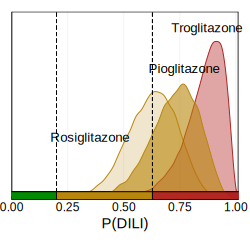

In [39]:
## ---------------------------------------------------------
## increasing human DILI - posteriors
## ---------------------------------------------------------
   
    # cutpoints
    c1 = logistic(mean(c1_est))
    c2 = logistic(mean(c2_est))

#---- Rosiglitazone ---------------------
    post = post_train

    ind = 62

    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    p1 = plot(dens.x, dens.density,  
              fill = (0, 0.2, :darkgoldenrod), 
              color = :darkgoldenrod, 
              #title = drug_names_train[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"))
    vline!([c1, c2], color = :black, linestyle = :dash)

    # define a function that returns a Plots.Shape
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

    plot!(rectangle(c1+0.05, 0.25, -0.05,0), color = :green4, alpha = 0.9)
    plot!(rectangle(c2-c1,0.25,c1,0), color = :darkgoldenrod, alpha = 0.9)
    plot!(rectangle(1.05-c2,0.25,c2,0), color = :firebrick, alpha = 0.9)

#---- Troglitazone ---------------------
    post = post_train

    ind = 115

    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    plot!(dens.x, dens.density,  
              fill = (0, 0.4, :firebrick), 
              color = :firebrick, 
              #title = drug_names_train[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"))
    vline!([c1, c2], color = :black, linestyle = :dash)

    # define a function that returns a Plots.Shape
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

    plot!(rectangle(c1+0.05, 0.25, -0.05,0), color = :green4, alpha = 0.9)
    plot!(rectangle(c2-c1,0.25,c1,0), color = :darkgoldenrod, alpha = 0.9)
    plot!(rectangle(1.05-c2,0.25,c2,0), color = :firebrick, alpha = 0.9)

#---- Pioglitazone ---------------------
    post = post_test

    ind = 6

    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    plot!(dens.x, dens.density,  
              fill = (0, 0.6, :darkgoldenrod), 
              color = :darkgoldenrod, 
             #title = drug_names_test[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(10, "Calibri"))
    vline!([c1, c2], color = :black, linestyle = :dash)

    # define a function that returns a Plots.Shape
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

    plot!(rectangle(c1+0.05, 0.25, -0.05,0), color = :green4, alpha = 0.9)
    plot!(rectangle(c2-c1,0.25,c1,0), color = :darkgoldenrod, alpha = 0.9)
    plot!(rectangle(1.05-c2,0.25,c2,0), color = :firebrick, alpha = 0.9)

#------- annotations ------------
    annotate!(0.87, 5.5, text("Troglitazone", :balck, 9))
    annotate!(0.77, 4.2, text("Pioglitazone", :balck, 9))
    annotate!(0.35, 2, text("Rosiglitazone", :balck, 9))

In [40]:
#savefig("figs/POLR_rosi_pio.pdf")

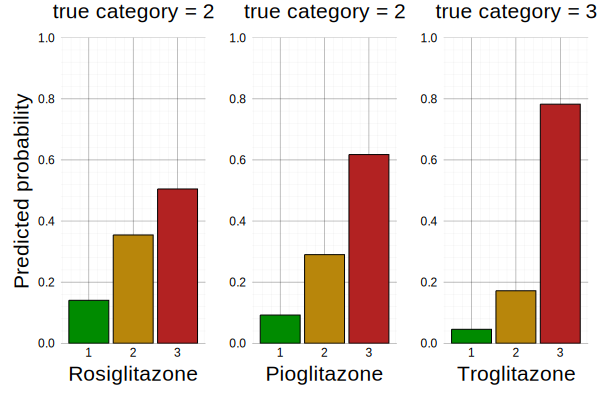

In [41]:
## ---------------------------------------------------------
## increasing human DILI - posterior predictive distributions
## ---------------------------------------------------------

#---- Rosiglitazone ---------------------
    y_pred_samps = y_pred_samps_train
    y = y_train
    drug_names = drug_names_train

    j = 62

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b1 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              yticks = true,
              framestyle = :grid,
              ylimit = (0,1),
              title = "true category = " * string(y[j]) , 
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              yguidefontsize=font(14, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);

#---- Troglitazone ---------------------
    y_pred_samps = y_pred_samps_train
    y = y_train   
    drug_names = drug_names_train

    j = 115

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b2 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              #ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              yticks = true,
              framestyle = :grid,
              ylimit = (0,1),
              title = "true category = " * string(y[j]) , 
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              yguidefontsize=font(14, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);
#---- Pioglitazone ---------------------
    y_pred_samps = y_pred_samps_test
    y = y_test
    drug_names = drug_names_test

    j = 6

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b3 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              #ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              #yticks = true,
              #yticks = false,
              framestyle = :grid,
              ylimit = (0,1),
              title = "true category = " * string(y[j]) , 
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              #yguidefontsize=font(14, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);

plot(b1, b3, b2, layout=(1, 3), label="")

In [42]:
#savefig("figs/POLR_rosi_pio_pred.pdf")

In [43]:
## ---------------------------------------------------------
## Predict for ambiguous-category data
## ---------------------------------------------------------

probs_mat_ambig, y_pred_samps_ambig, logpdf_mat_ambig, y_pred_ambig, eta_post_ambig = predict(X_ambig, false, n_samps);

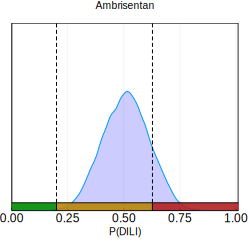

In [44]:
## extract predicted values and convert to 0-1 scale
post = logistic.(eta_post_ambig)
post_ambig = post

# cutpoints
c1 = logistic(mean(c1_est))
c2 = logistic(mean(c2_est))

postplot(drug_names_ambig, post_ambig, 2)

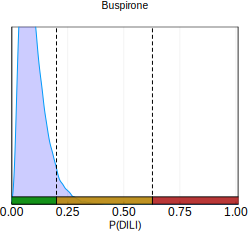

In [45]:
postplot(drug_names_ambig, post, 3)

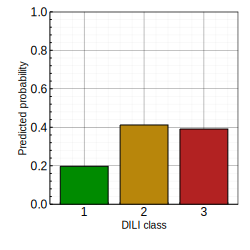

In [46]:
probsplot(drug_names_ambig, y_pred_samps_ambig, 2, false)

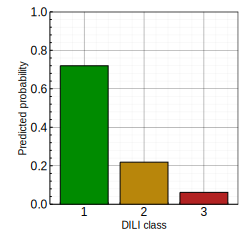

In [47]:
probsplot(drug_names_ambig, y_pred_samps_ambig, 3, false)

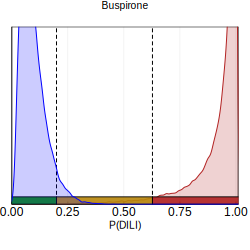

In [48]:
## ---------------------------------------------------------
## increasing human DILI - posteriors
## ---------------------------------------------------------
   
    # cutpoints
    c1 = logistic(mean(c1_est))
    c2 = logistic(mean(c2_est))

#---- Nefazodone ---------------------
    # ---------inputs----------
    post = post_train
    drug_names = drug_names_train
    ind = 112
    
    # ---------function---------
    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    p1 = plot(dens.x, dens.density,  
              fill = (0, 0.2, :firebrick), 
              color = :firebrick, 
              title = drug_names[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(7, "Calibri"),
              xguidefontsize=font(7, "Calibri"))
    vline!([c1, c2], color = :black, linestyle = :dash)

    # define a function that returns a Plots.Shape
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

    plot!(rectangle(c1+0.05, 0.25, -0.05,0), color = :green4, alpha = 0.9)
    plot!(rectangle(c2-c1,0.25,c1,0), color = :darkgoldenrod, alpha = 0.9)
    plot!(rectangle(1.05-c2,0.25,c2,0), color = :firebrick, alpha = 0.9)

#---- Buspirone ---------------------
    # ---------inputs----------
    post = post_ambig
    drug_names = drug_names_ambig
    ind = 3
    
    # ---------function---------
    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    plot!(dens.x, dens.density,  
              fill = (0, 0.2, :blue), 
              color = :blue, 
              title = drug_names[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(7, "Calibri"),
              xguidefontsize=font(7, "Calibri"))

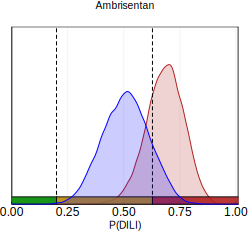

In [49]:
#---- Bosentan ---------------------
    # ---------inputs----------
    post = post_train
    drug_names = drug_names_train
    ind = 123
    
    # ---------function---------
    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    p2 = plot(dens.x, dens.density,  
              fill = (0, 0.2, :firebrick), 
              color = :firebrick, 
              title = drug_names[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              #size=[250,250],
              titlefont = font(7, "Calibri"),
              xguidefontsize=font(7, "Calibri"))
    vline!([c1, c2], color = :black, linestyle = :dash)

    # define a function that returns a Plots.Shape
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

    plot!(rectangle(c1+0.05, 0.25, -0.05,0), color = :green4, alpha = 0.9)
    plot!(rectangle(c2-c1,0.25,c1,0), color = :darkgoldenrod, alpha = 0.9)
    plot!(rectangle(1.05-c2,0.25,c2,0), color = :firebrick, alpha = 0.9)

#---- Ambrisentan ---------------------
    # ---------inputs----------
    post = post_ambig
    drug_names = drug_names_ambig
    ind = 2
    
    # ---------function---------
    post_ind = post[:,ind]
    
    post_ind = vcat(0, post_ind, 1)
    
    kde_npoints = 2048
    #dens = kde(post_ind, npoints=kde_npoints, bandwidth=0.1)
    dens = kde(post_ind, npoints=kde_npoints)

    plot!(dens.x, dens.density,  
              fill = (0, 0.2, :blue), 
              color = :blue, 
              title = drug_names[ind], 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(7, "Calibri"),
              xguidefontsize=font(7, "Calibri"))

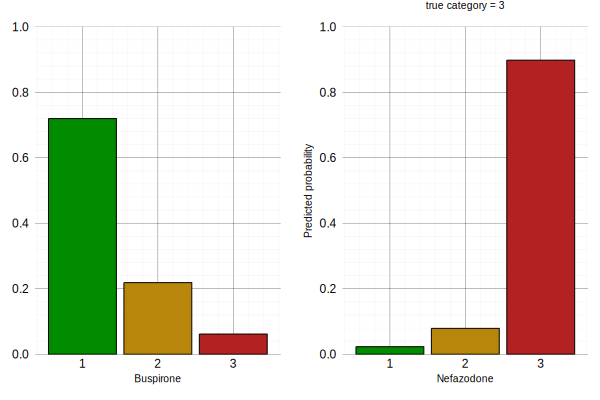

In [50]:
#---- Nefazodone ---------------------
    y_pred_samps = y_pred_samps_train
    y = y_train
    drug_names = drug_names_train

    j = 112

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b1 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              yticks = true,
              framestyle = :grid,
              ylimit = (0,1),
              title = "true category = " * string(y[j]) , 
              titlefont = font(7, "Calibri"),
              xguidefontsize=font(7, "Calibri"),
              yguidefontsize=font(7, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);

#---- Buspirone ---------------------
    y_pred_samps = y_pred_samps_ambig
#    y = y_train   
    drug_names = drug_names_ambig

    j = 3

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b2 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              #ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              yticks = true,
              framestyle = :grid,
              ylimit = (0,1),
              #title = "true category = " * string(y[j]) , 
              titlefont = font(7, "Calibri"),
              xguidefontsize=font(7, "Calibri"),
              yguidefontsize=font(7, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);

plot(b2, b1, layout=(1, 2), label="")

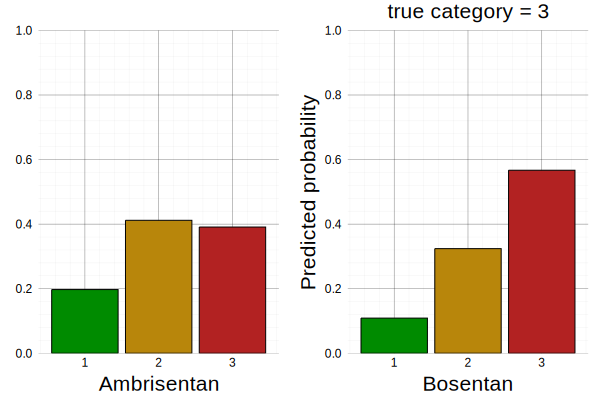

In [51]:
#---- Bozentan ---------------------
    y_pred_samps = y_pred_samps_train
    y = y_train
    drug_names = drug_names_train

    j = 123

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b1 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              yticks = true,
              framestyle = :grid,
              ylimit = (0,1),
              title = "true category = " * string(y[j]) , 
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              yguidefontsize=font(14, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);

#---- Buspirone ---------------------
    y_pred_samps = y_pred_samps_ambig
#    y = y_train   
    drug_names = drug_names_ambig

    j = 2

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    b2 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              #ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              yticks = true,
              framestyle = :grid,
              ylimit = (0,1),
              #title = "true category = " * string(y[j]) , 
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              yguidefontsize=font(14, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9);

plot(b2, b1, layout=(1, 2), label="")

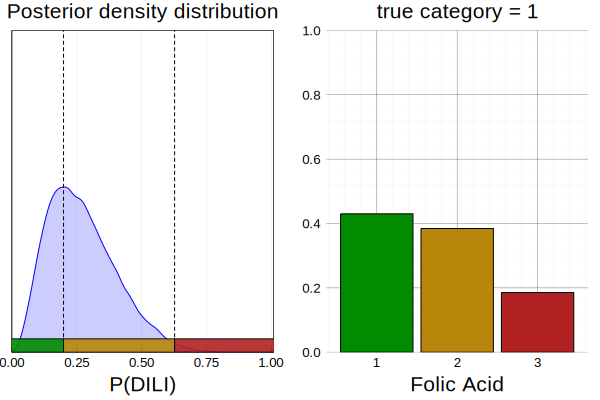

In [52]:
#---- Folic acid ---------------------
   # cutpoints
    c1 = logistic(mean(c1_est))
    c2 = logistic(mean(c2_est))

    post = post_test
    drug_names = drug_names_test

    ind = 30

    post_ind = post[:,ind]
  
    post_ind = vcat(0, post_ind, 1)

    kde_npoints = 2048
    dens = kde(post_ind, npoints=kde_npoints)

    p1 = plot(dens.x, dens.density,  
              fill = (0, 0.2, :blue), 
              color = :blue, 
              #title = drug_names[ind], 
              title = "Posterior density distribution", 
              xlabel="P(DILI)", 
              xlims = (0,1.01),
              ylims = (0,6),
              legend=false,
              yticks = false,
              framestyle = :box,
              size=[250,250],
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              tickfont=font(9))
   vline!([c1, c2], color = :black, linestyle = :dash)

    # define a function that returns a Plots.Shape
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

    plot!(rectangle(c1+0.05, 0.25, -0.05,0), color = :green4, alpha = 0.9)
    plot!(rectangle(c2-c1,0.25,c1,0), color = :darkgoldenrod, alpha = 0.9)
    plot!(rectangle(1.05-c2,0.25,c2,0), color = :firebrick, alpha = 0.9)

#---- Folic acid ---------------------
    y_pred_samps = y_pred_samps_test
    y = y_test

    j = 30

    tbl = freqtable(y_pred_samps[:,j])
    ptbl = prop(tbl)
    p2 = bar( ptbl, 
             labels="10 sin values", 
             #size=[150,250],
              xlabel=drug_names[j], 
              #ylabel="Predicted probability", 
              xticks = 1:1:3,
              legend=false,
              #yticks = true,
            #yticks = false,
              framestyle = :grid,
              ylimit = (0,1),
              title = "true category = " * string(y[j]) , 
              titlefont = font(14, "Calibri"),
              xguidefontsize=font(14, "Calibri"),
              #yguidefontsize=font(7, "Calibri"),
              #fillcolor = [:navy, :purple, :magenta],
              fillcolor = [:green4, :darkgoldenrod, :firebrick],
              #alpha= [0.9, 0.9,0.6],  
              minorgrid = true,
              #gridcolor = :black,
              gridopacity = 0.5,
              grid = :xy,
              bar_width = 0.9,
              tickfont=font(9));

plot(p1, p2, layout=(1, 2), label="")
   

In [53]:
#savefig("figs/POLR_FolicAcid.pdf")

In [54]:
using Pkg
Pkg.status()

    Status `~/Box Sync/27_BNN_DILI/Julia/Binder_BNN_tox/Project.toml`
  [336ed68f] CSV v0.5.9
  [a93c6f00] DataFrames v0.19.1
  [587475ba] Flux v0.8.3
  [da1fdf0e] FreqTables v0.3.1
  [4138dd39] JLD v0.9.2
  [5ab0869b] KernelDensity v0.5.1
  [f0e99cf1] MLBase v0.8.0
  [91a5bcdd] Plots v0.25.3
  [2913bbd2] StatsBase v0.32.0
  [4c63d2b9] StatsFuns v0.8.0
  [3eaba693] StatsModels v0.6.2
  [fce5fe82] Turing v0.6.23 #master (https://github.com/TuringLang/Turing.jl.git)
  [9a3f8284] Random 


In [44]:
# Pkg.add(Pkg.PackageSpec(;name="Turing", version="0.6.23"))